___
## <font color="#CA3532"> Cuantificación </font>

##### <font color="#CA7868"> TFM datos artificiales </font>
##### <font color="#CA7868"> AC, AC-OVR, HDY, OVR-HDy, HDX, OVR-HDx ,EDX, OVR-EDX,EDy, OVR-EDy </font>
##### <font color="#CA7868"> Abrán Yiu-sen Yuen Durán</font>

___

___
#### <font color="#CA3532"> Paquetes Necesarios </font>
___

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns # Necesario para plotear
import matplotlib.pyplot as plt # Necesario para plotear multiplot line
import os # Necesario para rutas

import time # Tiempo de ejecución
from datetime import timedelta # Tiempo ejecucion en hh:mm:ss

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV

from quantificationlib.base import UsingClassifiers
from quantificationlib.baselines.ac import AC
from quantificationlib.multiclass.em import EM
from quantificationlib.multiclass.df import HDy, HDX
from quantificationlib.multiclass.energy import EDX ,EDy
from quantificationlib.decomposition.multiclass import OneVsRestQuantifier
from quantificationlib.metrics.multiclass import mean_absolute_error
from quantificationlib.bag_generator import PriorShift_BagGenerator

import warnings
warnings.filterwarnings("ignore")

___
#### <font color="#CA3532"> Funciones Necesarios </font>
___

In [2]:
from sklearn.utils.validation import check_array, check_consistent_length
def check_prevalences(p_true, p_pred):
    """ Check that p_true and p_pred are valid and consistent

        Parameters
        ----------
        p_true : array_like, shape = (n_classes)
            True prevalences

        p_pred : array_like, shape = (n_classes)
            Predicted prevalences

        Returns
        -------
        p_true : array-like of shape = (n_classes, 1)
            The converted and validated p_true array

        p_pred : array-like of shape = (n_classes, 1)
            The converted and validated p_pred array
    """
    check_consistent_length(p_true, p_pred)
    p_true = check_array(p_true, ensure_2d=False)
    p_pred = check_array(p_pred, ensure_2d=False)

    if p_true.ndim == 1:
        p_true = p_true.reshape((-1, 1))

    if p_pred.ndim == 1:
        p_pred = p_pred.reshape((-1, 1))

    if p_true.shape[1] != p_pred.shape[1]:
        raise ValueError("p_true and p_pred have different length")

    return p_true, p_pred
def prueba(p_true, p_pred):
    """ Mean absolute error

            :math:`mae = 1/l \sum_{j=1}^{j=l} | p_j - \hat{p}_j |`

        being l the number of classes

        Parameters
        ----------
        p_true : array_like, shape = (n_classes)
            True prevalences

        p_pred : array_like, shape = (n_classes)
            Predicted prevalences

        Returns
        -------
        MAE : float
            It is equal to :math:`1/l \sum_{j=1}^{j=l} | p_j - \hat{p}_j |`
    """
    p_true, p_pred = check_prevalences(p_true, p_pred)
    
    return np.abs(p_pred)

# Función de preprocesado para tablon filtrado
def prepro(df):
    # Seleccionamos solo las variables necesarias
    # ========================================================================
    df_filtrado=df.loc[:,['nmethod','ntrain','mean_Error']]  

    # Agrupamos por media
    # ========================================================================
    df_filt_group=df_filtrado.groupby(by=["nmethod","ntrain"]).mean() 
    #reseteamos index
    # ========================================================================
    df_filt_group.reset_index(inplace=True) 
    # ========================================================================
    res = df_filt_group.pivot(index='ntrain', columns=('nmethod'), values='mean_Error')
    # Debido a que tenemos multi-index, volvemos a resetear el index
    # ========================================================================
    res=res.reset_index() 
    # Debido al indice generado por la operación group by la unica forma de asignar un nuevo index es creando una nueva tabla 
    # ========================================================================
    lst=res.loc[:,['ntrain']].values #Generamos lista para df
    df = pd.DataFrame(lst)
    #df.index = list(df["ntrain"])
    df_filtrado_recons = pd.merge(df, res, left_index=True, right_index=True) #
    df_filtrado_recons = df_filtrado_recons.iloc[:,1:]
    df_filtrado_recons.rename(columns = {'HDx':'HDX','OVR-HDx':'OVR-HDX'}, inplace = True)
    df_filtrado_recons=df_filtrado_recons.set_index('ntrain')
    return df_filtrado_recons

# Funcion para ver la distribucion min y max de probabilidades
def distribucion(df):

    sns.set(style="ticks")
    df=df
    fig, axs = plt.subplots(2, 2, figsize=(20, 5))

    sns.kdeplot(df['P_REAL_class_1'], shade=True,color="pink", ax=axs[0,0] )
    sns.kdeplot(df['P_REAL_class_2'], shade=True,color="plum", ax=axs[0,1]).set_title('Clase 2')
    sns.kdeplot(df['P_REAL_class_3'], shade=True,color="darkmagenta", ax=axs[1,0]).set_title('Clase 3')
    sns.kdeplot(df['P_REAL_class_4'], shade=True,color="midnightblue", ax=axs[1,1]).set_title('Clase 4')
    plt.show()

    # Mostramos rango de valores en cada clase para filtrar
    # ==========================================================
    descrip=df.describe().loc[['min','max'],['P_REAL_class_1','P_REAL_class_2','P_REAL_class_3','P_REAL_class_4']]
    return descrip

* Generación de valores artificiales

* Cuantificacion según dístintos métodos

* Comparativa gráfica de MAE

In [3]:
# 1) Función para generar valores artificiales
# ========================================================================
def datos(m11,m12,m21,m22,m31,m32,m41,m42,cova11,cova12,cova21,cova22,n_puntos,title):
    
    # n_puntos: Número de puntos por categoría
    
    # Centroides 
    # ======================
    mu1 = [m11, m12]
    mu2 = [m22, m22]
    mu3 = [m31, m32]
    mu4 = [m41, m42]

    # Dispersion de puntos Covarianzas
    # ======================
    cov1 = [[cova11, cova12],
           [cova21, cova22]]
    cov2 = cov1
    cov3 = cov1
    cov4 = cov1

    # Generacion aleatoria de puntos según el centroide y dispersión
    # Puntos generados con distribución Multivariante
    # Generación de clases
    # ======================
    seed=123
    rng=np.random.RandomState(seed)
    factor_X= np.vstack(( 
                         rng.multivariate_normal(mu1, cov1, n_puntos),
                         rng.multivariate_normal(mu2, cov2, n_puntos),
                         rng.multivariate_normal(mu3, cov3, n_puntos),
                         rng.multivariate_normal(mu4, cov4, n_puntos)))


    factor_Y = np.hstack((np.ones(n_puntos, dtype=int),
                        np.ones(n_puntos, dtype=int) * 2,
                        np.ones(n_puntos, dtype=int) * 3,
                        np.ones(n_puntos, dtype=int) * 4)) 

    # Generacion de DataFrame con dos variables y Factor Clase con 4 clases
    # ======================
    df= pd.DataFrame(factor_X, columns = ['X1','X2'])
    df['Clase'] = factor_Y

    g=sns.pairplot(  vars=["X1","X2"], data=df, hue="Clase")
    g.fig.suptitle(title, y=1.08)
    
# 2) Función para cuantificar según dístintos métodos
# ========================================================================    
def cuanti(m11,m12,m21,m22,m31,m32,m41,m42,cova11,cova12,cova21,cova22,est_name,ntrain,ntest,nreps ,nbags,title):
    seed=123
    rng = np.random.RandomState(seed)

    # Dataset 2D
    mu1 = [m11, m12]
    mu2 = [m21, m22]
    mu3 = [m31, m32]
    mu4 = [m41, m42]

    cov1 = [[cova11, cova12],
           [cova21, cova22]]
    cov2 = cov1
    cov3 = cov1
    cov4 = cov1



    #   methods
    # Multivariantes
    ac = AC(distance='L2')
    em = EM()
    hdy = HDy(n_bins=8)
    hdx = HDX(n_bins=8)
    edx = EDX()
    edy = EDy()

    # One vs Res
    ovr_ac = OneVsRestQuantifier(base_quantifier=AC())
    ovr_em = OneVsRestQuantifier(base_quantifier=EM())
    ovr_hdy = OneVsRestQuantifier(base_quantifier=HDy(n_bins=8))
    ovr_hdx = OneVsRestQuantifier(base_quantifier=HDX(n_bins=8))
    ovr_edx = OneVsRestQuantifier(base_quantifier=EDX())
    ovr_edy = OneVsRestQuantifier(base_quantifier=EDy())

    methods = [ac, em, hdy, hdx, edx,  edy,ovr_ac, ovr_em, ovr_hdy, ovr_hdx, ovr_edx,ovr_edy]
    methods_names = ['AC','EM','HDy','HDx','EDX','EDy','OVR-AC','OVR-EM','OVR-HDy','OVR-HDx','OVR-EDX','OVR-EDy']
 
    #   to store all the quant_results
    quant_results = np.zeros((len(methods_names), len(ntrain)))
    print('')
    print('Total bags', nbags)
    print('Total repeticiones', nreps)
    print('Tamaño test', ntest)
    print('Total train', ntrain)
    print('estimador',est_name)
    print('')
    
    #---------
    #--------- Nuevo
    #--------- 
    df_proba = pd.DataFrame([])
    df_proba2 = pd.DataFrame([])
    df_proba3 = pd.DataFrame([])
    #---------
    #--------- Fin de Nuevo
    #--------- 
    
    for k in range(len(ntrain)):

        all_quant_results = np.zeros((len(methods_names), nreps * nbags))

        print('\n#Training examples ', ntrain[k], 'Rep#', end=' ')

        for rep in range(nreps):

            print(rep+1, end=' ', flush=True)

            x_train = np.vstack((rng.multivariate_normal(mu1, cov1, ntrain[k]),
                                 rng.multivariate_normal(mu2, cov2, ntrain[k]),
                                 rng.multivariate_normal(mu3, cov3, ntrain[k]),
                                 rng.multivariate_normal(mu4, cov4, ntrain[k])))

            y_train = np.hstack((np.ones(ntrain[k], dtype=int),
                                 np.ones(ntrain[k], dtype=int) * 2,
                                 np.ones(ntrain[k], dtype=int) * 3, 
                                 np.ones(ntrain[k], dtype=int) * 4))

            #  binary estimator
            if est_name == 'CalRF':
                estimator = CalibratedClassifierCV(RandomForestClassifier(n_estimators=100, random_state=seed,
                                                                          class_weight='balanced'))                
            
            elif est_name == 'RF':
                estimator = RandomForestClassifier(n_estimators=100, random_state=seed, class_weight='balanced')
            elif est_name == 'LR':
                estimator = LogisticRegression(C=1, random_state=seed, max_iter=10000, solver='liblinear')

            #  one vs rest estimator
            ovr_estimator = OneVsRestClassifier(estimator, n_jobs=-1)

            estimator.fit(x_train, y_train)
            predictions_train = estimator.predict_proba(x_train)

            ovr_estimator.fit(x_train, y_train)
            ovr_predictions_train = ovr_estimator.predict_proba(x_train)

            for nmethod, method in enumerate(methods):
                if isinstance(method, UsingClassifiers):
                    if isinstance(method, OneVsRestQuantifier):
                        method.fit(X=x_train, y=y_train, predictions_train=ovr_predictions_train)
                    else:
                        method.fit(X=x_train, y=y_train, predictions_train=predictions_train)
                else:
                    method.fit(X=x_train, y=y_train)

            x_test = np.vstack((rng.multivariate_normal(mu1, cov1, ntest),
                                rng.multivariate_normal(mu2, cov2, ntest),
                                rng.multivariate_normal(mu3, cov3, ntest),
                                rng.multivariate_normal(mu4, cov4, ntest)))

            y_test = np.hstack((np.ones(ntest, dtype=int),
                                np.ones(ntest, dtype=int) * 2,
                                np.ones(ntest, dtype=int) * 3,
                                np.ones(ntest, dtype=int) * 4))

            predictions_test = estimator.predict_proba(x_test)
            ovr_predictions_test = ovr_estimator.predict_proba(x_test)

            #  Testing bags
            bag_generator = PriorShift_BagGenerator(n_bags=nbags, bag_size=ntest,
                                                    min_prevalence=None, random_state=seed + rep + 10)
                                                    #min_prevalence=[0.4,0,0,0.3], random_state=seed + rep + 10)

            prev_true, indexes = bag_generator.generate_bags(x_test, y_test)

            for n_bag in range(nbags):

                for nmethod, method in enumerate(methods):
                    if isinstance(method, UsingClassifiers):
                        if isinstance(method, OneVsRestQuantifier):
                            if isinstance(method.base_quantifier, UsingClassifiers):
                                p_predicted = method.predict(X=None,
                                                             predictions_test=ovr_predictions_test[indexes[:, n_bag], :])
                            else:
                                p_predicted = method.predict(X=x_test[indexes[:, n_bag], :])
                        else:
                            p_predicted = method.predict(X=None,
                                                         predictions_test=predictions_test[indexes[:, n_bag], :])
                    else:
                        p_predicted = method.predict(X=x_test[indexes[:, n_bag], :])
                    
                    #---------
                    #--------- Nuevo
                    #--------- 
                    # Tabla con propensiones
                    # Construcción de DF con las probabilidades por clase
                    # ===========================================================================
                    all_quant_results2=prueba(prev_true[:, n_bag],p_predicted).T
                    data = pd.DataFrame(all_quant_results2)
                    #data['Coordenadas']=x_test[indexes[:, n_bag], :]
                    data['method']=method
                    data['nmethod']=nmethod
                    data['nbags'] = nbags
                    data['nreps'] = nreps
                    data['Est_name'] = est_name
                    data['ntrain'] = ntrain[k]
                    #data['x_test']= X
                    #data['x_test']= x_test
                    data.rename(columns = {0:'Prob_class_1', 1:'Prob_class_2',2:'Prob_class_3',3:'Prob_class_4'}, inplace = True)
                    df_proba = df_proba.append(data)  
                    df_proba['nmethod'] = df_proba['nmethod'].replace([0,1,2,3,4,5,6,7,8,9,10,11],['AC','EM','HDy','HDx','EDX','EDy','OVR-AC','OVR-EM','OVR-HDy','OVR-HDx','OVR-EDX','OVR-EDy'])
                    #print(df_proba.head())
                    # Fin de tabla con propensiones
                    # ===========================================================================

                    # ===========================================================================
                    all_quant_results_est=pd.DataFrame(prev_true[:, n_bag]).T #propensiones estimadas
                    df_est=pd.DataFrame(all_quant_results_est)
                    df_proba2 = df_proba2.append(df_est) 


                    all_quant_results_real=pd.DataFrame(p_predicted).T   # propensiones reales
                    df_real=pd.DataFrame(all_quant_results_real)
                    df_proba3 = df_proba3.append(df_real) 
                    #---------
                    #--------- Fin de Nuevo
                    #---------
                    
                    all_quant_results[nmethod, rep * nbags + n_bag] = mean_absolute_error(prev_true[:, n_bag],
                                                                                          p_predicted)

                    quant_results[nmethod, k] = quant_results[nmethod, k] + \
                                                all_quant_results[nmethod, rep * nbags + n_bag]
    #---------
    #--------- Nuevo
    #---------
    df_proba2.rename(columns = {0:'P_REAL_class_1', 1:'P_REAL_class_2',2:'P_REAL_class_3',3:'P_REAL_class_4'}, inplace = True)
    df_proba3.rename(columns = {0:'P_EST_class_1', 1:'P_EST_class_2',2:'P_EST_class_3',3:'P_EST_class_4'}, inplace = True)
    df_proba_real= pd.concat([df_proba2, df_proba3], axis=1)
    df_proba_real= pd.concat([df_proba, df_proba_real], axis=1)
    df_proba_real= df_proba_real.iloc[:,5:]
    #---------
    #--------- Fin de Nuevo
    #---------
    quant_results = quant_results / (nreps * nbags) # Se normaliza la salida, ya que los clasificadores son independientes. Es una forma de asegurar que todo suma 1
    # Unimos todos los métodos por tamaño de train
    df=pd.merge(pd.DataFrame(methods_names, columns=['n_train']), 
                pd.DataFrame(quant_results, columns=ntrain), 
             left_index=True, right_index=True)

    df_t = df.transpose()
    df_t.columns = df_t.iloc[0]
    df_t=df_t[1:]
    df_t['Est_name'] = est_name
    df_t['Dispersion'] = cova11
    
    df_t['ntest'] = ntest
    df_t['nreps'] = nreps
    df_t['nbags'] = nbags

    
    
    #name_file = '/Users/abran.yuen/TFM_OVR/'+title + '-avg-artificial-multiclass-' + est_name + '-rep' + str(nreps) + \
    name_file = title + '-avg-artificial-multiclass-' + est_name + '-rep' + str(nreps) + \
                '-ntest' + str(ntest) + '.txt'
    file_avg = open(name_file, 'w')
    file_avg.write('#examples, ')
    for index, m in enumerate(methods_names):
        file_avg.write('%s, ' % m)
    for index, number in enumerate(ntrain):
        file_avg.write('\n%d, ' % number)
        for i in quant_results[:, index]:
            file_avg.write('%.5f, ' % i)

    file_avg.close()
    
    # Inicio proceso para guardar tabla propensiones
    df_proba_real=df_proba_real.reset_index()
    #df_proba_real.to_csv('/Users/abran.yuen/TFM_OVR/'+title + '-Prob-artificial-multiclass-' + est_name + '-rep' + str(nreps) + \
    df_proba_real.to_csv(title + '-Prob-artificial-multiclass-' + est_name + '-rep' + str(nreps) + \
                '-ntest' + str(ntest) + '.csv') 
    
    
    # Eliminamos el caso EM
    df_t=df_t.drop(['EM', 'OVR-EM'], axis=1)
    df_proba_real =df_proba_real.loc[(df_proba_real['nmethod']!='EM') & (df_proba_real['nmethod']!='OVR-EM') ]
    
    return df_t , df_proba_real

# 3) Comparativa gráfica de MAE por método y tamaño de train
# ========================================================================    
def comp_line(df):
    fig = plt.figure(figsize=(18,3))
    fig = plt.figure(figsize=(18,3))
    ax1 = plt.subplot(151)
    ax2 = plt.subplot(152)
    ax3 = plt.subplot(153)
    ax4 = plt.subplot(154)
    ax5 = plt.subplot(155)
    df.plot(y=['AC','OVR-AC'],ax=ax1)
    df.plot(y=['HDX','OVR-HDX'],ax=ax2)
    df.plot(y=['HDy','OVR-HDy'],ax=ax3)
    df.plot(y=['EDX','OVR-EDX'],ax=ax4)
    df.plot(y=['EDy','OVR-EDy'],ax=ax5)
    plt.tight_layout()
    return plt.show()


### <font color="#CA3532"> 1. Experimentación
### <font color="#CA3532"> 1.1 Estado inicial
    
    Se genera un conjunto de datos artificiales compuesto por un total de 4 grupos. Estos se generan mediante una distribucion normal


Total bags 50
Total repeticiones 10
Tamaño test 1000
Total train [1000]
estimador LR


#Training examples  1000 Rep# 1 2 3 4 5 6 7 8 9 10 --- 0:03:02.418596 TIME ---


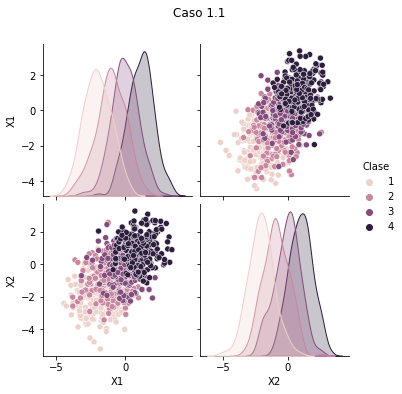

In [4]:
# -- > PASO 1)
# Caso 1.01
start_time = time.time()

# ========================================================================    
datos(m11=-2,m12=-2,
      m21=-1,m22=-1,
      m31=0,m32=0,
      m41=1,m42=1,
      cova11=1,cova12=0,
      cova21=0,cova22=1, n_puntos=200, title='Caso 1.1')

# Cuantificación
# ========================================================================    
df_caso1_01=cuanti(m11=-2,m12=-2,
                   m21=-1,m22=-1,
                   m31=0,m32=0,
                   m41=1,m42=1,
                   cova11=1,cova12=0,
                   cova21=0,cova22=1, 
                   est_name='LR',ntrain=[1000],ntest=1000,nreps=10 ,nbags=50, title='Caso_1.1')
                   #ntrain=[50,100,200,500,1000,1500]


# Comparativa gráfica de MAE por método y tamaño de train
# ========================================================================    
#comp_line(df_caso1_01[0])

elapsed = (time.time() - start_time)

print("--- %s TIME ---" % str(timedelta(seconds=elapsed)))


### <font color="#CA3532"> 1.2 MAE original, Probabilidades originales, Distribuciones original
    
    En este punto se muestra las probabilidades reales y estimadas para cada método así como las funciones de distribución

In [5]:
# -- > PASO 2
# MAE ORIGINAL
# ========================================================================    
df_total=df_caso1_01[0] 
df_total

n_train,AC,HDy,HDx,EDX,EDy,OVR-AC,OVR-HDy,OVR-HDx,OVR-EDX,OVR-EDy,Est_name,Dispersion,ntest,nreps,nbags
1000,0.0475804,0.0268015,0.0377431,0.0296468,0.0298978,0.260202,0.103603,0.114651,0.140426,0.109096,LR,1,1000,10,50


In [6]:
# -- > PASO 3
# PROBABILIDAES ORIGINALES
# ========================================================================    
df_proba_real=df_caso1_01[1]
df_proba_real.head()

,index,nmethod,nbags,nreps,Est_name,ntrain,P_REAL_class_1,P_REAL_class_2,P_REAL_class_3,P_REAL_class_4,P_EST_class_1,P_EST_class_2,P_EST_class_3,P_EST_class_4
0,0,AC,50,10,LR,1000,0.056,0.617,0.231,0.096,0.004079,0.752770,0.088642,0.154509
2,0,HDy,50,10,LR,1000,0.056,0.617,0.231,0.096,0.037126,0.650283,0.213247,0.099345
3,0,HDx,50,10,LR,1000,0.056,0.617,0.231,0.096,0.026277,0.668583,0.222455,0.082685
4,0,EDX,50,10,LR,1000,0.056,0.617,0.231,0.096,0.051190,0.625916,0.231993,0.090902
5,0,EDy,50,10,LR,1000,0.056,0.617,0.231,0.096,0.070538,0.583169,0.261865,0.084428


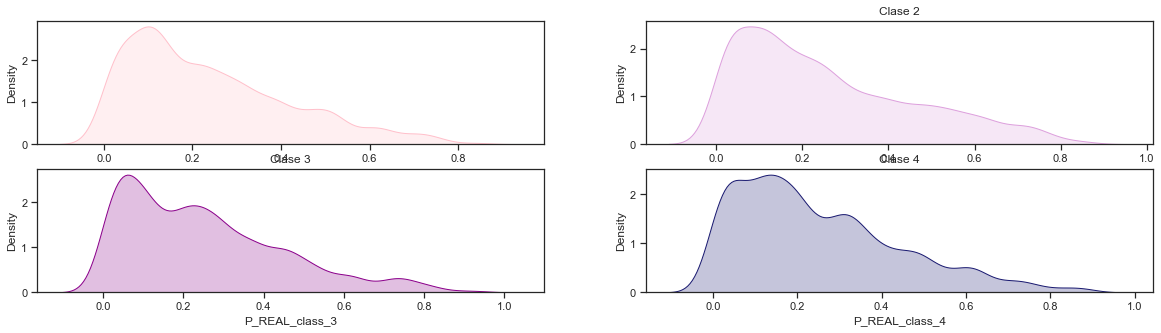

,P_REAL_class_1,P_REAL_class_2,P_REAL_class_3,P_REAL_class_4
min,0.000,0.001,0.001,0.001
max,0.843,0.849,0.933,0.883


In [7]:
# -- > PASO 4
# DISTRIBUCIONES ORIGINALES
# ========================================================================   
distribucion(df_proba_real)

### <font color="#CA3532">  Gráfico MAE vs Diferencias entre reaal y homogeneo

#### Es importante tener en cuenta que este apartado gráfico es exclusivamente para los métodos de OVR

### <font color="#CA3532">  Caso 0VR-AC

In [8]:
df_proba_real=df_caso1_01[1].copy()
df_proba_real.head()

,index,nmethod,nbags,nreps,Est_name,ntrain,P_REAL_class_1,P_REAL_class_2,P_REAL_class_3,P_REAL_class_4,P_EST_class_1,P_EST_class_2,P_EST_class_3,P_EST_class_4
0,0,AC,50,10,LR,1000,0.056,0.617,0.231,0.096,0.004079,0.752770,0.088642,0.154509
2,0,HDy,50,10,LR,1000,0.056,0.617,0.231,0.096,0.037126,0.650283,0.213247,0.099345
3,0,HDx,50,10,LR,1000,0.056,0.617,0.231,0.096,0.026277,0.668583,0.222455,0.082685
4,0,EDX,50,10,LR,1000,0.056,0.617,0.231,0.096,0.051190,0.625916,0.231993,0.090902
5,0,EDy,50,10,LR,1000,0.056,0.617,0.231,0.096,0.070538,0.583169,0.261865,0.084428


In [9]:
def Dist_Homo_MAE(df,metodo):
    # Se filtra por método OVR 
    df_filtrado_OVR = df[(df['nmethod'] == metodo)]

    # Caso Q1
    df_filtrado_OVR['Q1_diff'] = 1- df_filtrado_OVR ['P_REAL_class_1'] 
    df_filtrado_OVR['Homogeneo'] = df_filtrado_OVR['Q1_diff']/3
    df_filtrado_OVR['dif_Q2_HOMO'] = abs(df_filtrado_OVR['P_REAL_class_2'] - df_filtrado_OVR['Homogeneo'])
    df_filtrado_OVR['dif_Q3_HOMO'] = abs(df_filtrado_OVR['P_REAL_class_3'] - df_filtrado_OVR['Homogeneo'])
    df_filtrado_OVR['dif_Q4_HOMO'] = abs(df_filtrado_OVR['P_REAL_class_4'] - df_filtrado_OVR['Homogeneo'])
    df_filtrado_OVR['dif_Q1_mean'] = (df_filtrado_OVR['dif_Q2_HOMO']+df_filtrado_OVR['dif_Q3_HOMO']+df_filtrado_OVR['dif_Q4_HOMO'])/3
    df_filtrado_OVR['MAE_Q1'] =  abs(df_filtrado_OVR['P_REAL_class_1'] - df_filtrado_OVR['P_EST_class_1'])
    #df_filtrado_OVR['dif_Q1_var'] = 
    

    # Caso Q2
    df_filtrado_OVR['Q2_diff'] = 1- df_filtrado_OVR ['P_REAL_class_2'] 
    df_filtrado_OVR['Homogeneo'] = df_filtrado_OVR['Q2_diff']/3
    df_filtrado_OVR['dif_Q1_HOMO'] = abs(df_filtrado_OVR['P_REAL_class_1'] - df_filtrado_OVR['Homogeneo'])
    df_filtrado_OVR['dif_Q3_HOMO'] = abs(df_filtrado_OVR['P_REAL_class_3'] - df_filtrado_OVR['Homogeneo'])
    df_filtrado_OVR['dif_Q4_HOMO'] = abs(df_filtrado_OVR['P_REAL_class_4'] - df_filtrado_OVR['Homogeneo'])
    df_filtrado_OVR['dif_Q2_mean'] = (df_filtrado_OVR['dif_Q1_HOMO']+df_filtrado_OVR['dif_Q3_HOMO']+df_filtrado_OVR['dif_Q4_HOMO'])/3
    df_filtrado_OVR['MAE_Q2'] =  abs(df_filtrado_OVR['P_REAL_class_2'] - df_filtrado_OVR['P_EST_class_2'])

    # Caso Q3
    df_filtrado_OVR['Q3_diff'] = 1- df_filtrado_OVR ['P_REAL_class_3'] 
    df_filtrado_OVR['Homogeneo'] = df_filtrado_OVR['Q3_diff']/3
    df_filtrado_OVR['dif_Q1_HOMO'] = abs(df_filtrado_OVR['P_REAL_class_1'] - df_filtrado_OVR['Homogeneo'])
    df_filtrado_OVR['dif_Q2_HOMO'] = abs(df_filtrado_OVR['P_REAL_class_2'] - df_filtrado_OVR['Homogeneo'])
    df_filtrado_OVR['dif_Q4_HOMO'] = abs(df_filtrado_OVR['P_REAL_class_4'] - df_filtrado_OVR['Homogeneo'])
    df_filtrado_OVR['dif_Q3_mean'] = (df_filtrado_OVR['dif_Q1_HOMO']+df_filtrado_OVR['dif_Q2_HOMO']+df_filtrado_OVR['dif_Q4_HOMO'])/3
    df_filtrado_OVR['MAE_Q3'] =  abs(df_filtrado_OVR['P_REAL_class_3'] - df_filtrado_OVR['P_EST_class_3'])

    # Caso Q4
    df_filtrado_OVR['Q4_diff'] = 1- df_filtrado_OVR ['P_REAL_class_4'] 
    df_filtrado_OVR['Homogeneo'] = df_filtrado_OVR['Q4_diff']/3
    df_filtrado_OVR['dif_Q1_HOMO'] = abs(df_filtrado_OVR['P_REAL_class_1'] - df_filtrado_OVR['Homogeneo'])
    df_filtrado_OVR['dif_Q2_HOMO'] = abs(df_filtrado_OVR['P_REAL_class_2'] - df_filtrado_OVR['Homogeneo'])
    df_filtrado_OVR['dif_Q3_HOMO'] = abs(df_filtrado_OVR['P_REAL_class_3'] - df_filtrado_OVR['Homogeneo'])
    df_filtrado_OVR['dif_Q4_mean'] = (df_filtrado_OVR['dif_Q1_HOMO']+df_filtrado_OVR['dif_Q2_HOMO']+df_filtrado_OVR['dif_Q3_HOMO'])/3
    df_filtrado_OVR['MAE_Q4'] =  abs(df_filtrado_OVR['P_REAL_class_4'] - df_filtrado_OVR['P_EST_class_4'])
    return df_filtrado_OVR;

# Funcion para ver la distribucion min y max de probabilidades
def plt_MAE_DIFhomo(df,titulo):
    
    sns.set(style="ticks")
    df=df
    fig, axs = plt.subplots(2, 2, figsize=(20, 5))
    
    sns.scatterplot(data=df, x="dif_Q1_mean", y="MAE_Q1",ax=axs[0,0]).set_title(titulo)
    sns.scatterplot(data=df, x="dif_Q2_mean", y="MAE_Q2",ax=axs[0,1]).set_title(titulo)
    sns.scatterplot(data=df, x="dif_Q3_mean", y="MAE_Q3",ax=axs[1,0])
    sns.scatterplot(data=df, x="dif_Q4_mean", y="MAE_Q4",ax=axs[1,1])
    plt.show()

    # Mostramos rango de valores en cada clase para filtrar
    # ==========================================================
    descrip=df.describe().loc[['min','max'],['MAE_Q1','MAE_Q2','MAE_Q3','MAE_Q4','dif_Q1_mean','dif_Q2_mean','dif_Q3_mean','dif_Q4_mean']]
    return descrip;

# Funcion de preprocesado y union de datos OVR con multivariante
def prepro_append(df,df_real,metodo):# Identify marca las coordenadas de registros para ser cruzados 
    identify=df[['ntrain','P_REAL_class_1','P_REAL_class_2','P_REAL_class_3','P_REAL_class_4']] 
    # Se identifica casos de AC
    df_proba_real = df_real[(df_real['nmethod'] == metodo )] 
    # Se cruca los casos de AC con Identify para poder dibujar las curvas multivariantes vs OVR
    identify_multivar = pd.merge(identify , df_proba_real, on=['ntrain','P_REAL_class_1', 'P_REAL_class_2', 'P_REAL_class_3','P_REAL_class_4'], how='inner')

    # append
    df_filtrado_OVR_plot = df_filtrado_OVR.append(identify_multivar)
    #df_filtrado_OVR_AC_plot.shape

    # Prepro
    df_filtrado_prep_OVR=prepro(df_filtrado_OVR_plot)
    return df_filtrado_prep_OVR


In [10]:
df_filtrado_OVR = Dist_Homo_MAE(df_proba_real,'OVR-AC')
df_filtrado_OVR

,index,nmethod,nbags,nreps,Est_name,ntrain,P_REAL_class_1,P_REAL_class_2,P_REAL_class_3,P_REAL_class_4,...,Q2_diff,dif_Q1_HOMO,dif_Q2_mean,MAE_Q2,Q3_diff,dif_Q3_mean,MAE_Q3,Q4_diff,dif_Q4_mean,MAE_Q4
6,0,OVR-AC,50,10,LR,1000,0.056,0.617,0.231,0.096,...,0.383,0.245333,0.068889,0.617,0.769,0.240444,0.231,0.904,0.210444,0.154575
18,0,OVR-AC,50,10,LR,1000,0.101,0.194,0.384,0.321,...,0.806,0.125333,0.111778,0.194,0.616,0.077111,0.384,0.679,0.105111,0.508247
30,0,OVR-AC,50,10,LR,1000,0.175,0.246,0.258,0.321,...,0.754,0.051333,0.050889,0.246,0.742,0.049111,0.258,0.679,0.034222,0.296031
42,0,OVR-AC,50,10,LR,1000,0.327,0.396,0.103,0.174,...,0.604,0.051667,0.083778,0.396,0.897,0.083333,0.103,0.826,0.114889,0.045434
54,0,OVR-AC,50,10,LR,1000,0.116,0.282,0.069,0.533,...,0.718,0.039667,0.195778,0.282,0.931,0.148444,0.069,0.467,0.084222,0.295673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5946,0,OVR-AC,50,10,LR,1000,0.395,0.035,0.086,0.484,...,0.965,0.223000,0.157111,0.035,0.914,0.179778,0.086,0.516,0.148667,0.095100
5958,0,OVR-AC,50,10,LR,1000,0.246,0.293,0.371,0.090,...,0.707,0.057333,0.097111,0.293,0.629,0.079778,0.371,0.910,0.045111,0.219289
5970,0,OVR-AC,50,10,LR,1000,0.320,0.116,0.336,0.228,...,0.884,0.062667,0.044444,0.116,0.664,0.070222,0.336,0.772,0.094222,0.239984
5982,0,OVR-AC,50,10,LR,1000,0.230,0.140,0.377,0.253,...,0.860,0.019000,0.060222,0.140,0.623,0.045111,0.377,0.747,0.085333,0.334836


In [11]:
df_filtrado_OVR.columns

Index(['index', 'nmethod', 'nbags', 'nreps', 'Est_name', 'ntrain',
       'P_REAL_class_1', 'P_REAL_class_2', 'P_REAL_class_3', 'P_REAL_class_4',
       'P_EST_class_1', 'P_EST_class_2', 'P_EST_class_3', 'P_EST_class_4',
       'Q1_diff', 'Homogeneo', 'dif_Q2_HOMO', 'dif_Q3_HOMO', 'dif_Q4_HOMO',
       'dif_Q1_mean', 'MAE_Q1', 'Q2_diff', 'dif_Q1_HOMO', 'dif_Q2_mean',
       'MAE_Q2', 'Q3_diff', 'dif_Q3_mean', 'MAE_Q3', 'Q4_diff', 'dif_Q4_mean',
       'MAE_Q4'],
      dtype='object')

In [12]:
df_filtrado_OVR[['P_REAL_class_1', 'P_REAL_class_2', 'P_REAL_class_3', 'P_REAL_class_4',
       'P_EST_class_1', 'P_EST_class_2', 'P_EST_class_3', 'P_EST_class_4', 'Homogeneo','Q1_diff','MAE_Q1']]

,P_REAL_class_1,P_REAL_class_2,P_REAL_class_3,P_REAL_class_4,P_EST_class_1,P_EST_class_2,P_EST_class_3,P_EST_class_4,Homogeneo,Q1_diff,MAE_Q1
6,0.056,0.617,0.231,0.096,0.749425,0.0,0.0,0.250575,0.301333,0.944,0.693425
18,0.101,0.194,0.384,0.321,0.170753,0.0,0.0,0.829247,0.226333,0.899,0.069753
30,0.175,0.246,0.258,0.321,0.382969,0.0,0.0,0.617031,0.226333,0.825,0.207969
42,0.327,0.396,0.103,0.174,0.780566,0.0,0.0,0.219434,0.275333,0.673,0.453566
54,0.116,0.282,0.069,0.533,0.171327,0.0,0.0,0.828673,0.155667,0.884,0.055327
...,...,...,...,...,...,...,...,...,...,...,...
5946,0.395,0.035,0.086,0.484,0.420900,0.0,0.0,0.579100,0.172000,0.605,0.025900
5958,0.246,0.293,0.371,0.090,0.690711,0.0,0.0,0.309289,0.303333,0.754,0.444711
5970,0.320,0.116,0.336,0.228,0.532016,0.0,0.0,0.467984,0.257333,0.680,0.212016
5982,0.230,0.140,0.377,0.253,0.412164,0.0,0.0,0.587836,0.249000,0.770,0.182164


In [13]:
df_filtrado_OVR[[ 'Q2_diff', 'dif_Q1_HOMO',
       'dif_Q2_mean', 'MAE_Q2', 'Q3_diff', 'dif_Q3_mean', 'MAE_Q3', 'Q4_diff',
       'dif_Q4_mean', 'MAE_Q4']]

,Q2_diff,dif_Q1_HOMO,dif_Q2_mean,MAE_Q2,Q3_diff,dif_Q3_mean,MAE_Q3,Q4_diff,dif_Q4_mean,MAE_Q4
6,0.383,0.245333,0.068889,0.617,0.769,0.240444,0.231,0.904,0.210444,0.154575
18,0.806,0.125333,0.111778,0.194,0.616,0.077111,0.384,0.679,0.105111,0.508247
30,0.754,0.051333,0.050889,0.246,0.742,0.049111,0.258,0.679,0.034222,0.296031
42,0.604,0.051667,0.083778,0.396,0.897,0.083333,0.103,0.826,0.114889,0.045434
54,0.718,0.039667,0.195778,0.282,0.931,0.148444,0.069,0.467,0.084222,0.295673
...,...,...,...,...,...,...,...,...,...,...
5946,0.965,0.223000,0.157111,0.035,0.914,0.179778,0.086,0.516,0.148667,0.095100
5958,0.707,0.057333,0.097111,0.293,0.629,0.079778,0.371,0.910,0.045111,0.219289
5970,0.884,0.062667,0.044444,0.116,0.664,0.070222,0.336,0.772,0.094222,0.239984
5982,0.860,0.019000,0.060222,0.140,0.623,0.045111,0.377,0.747,0.085333,0.334836


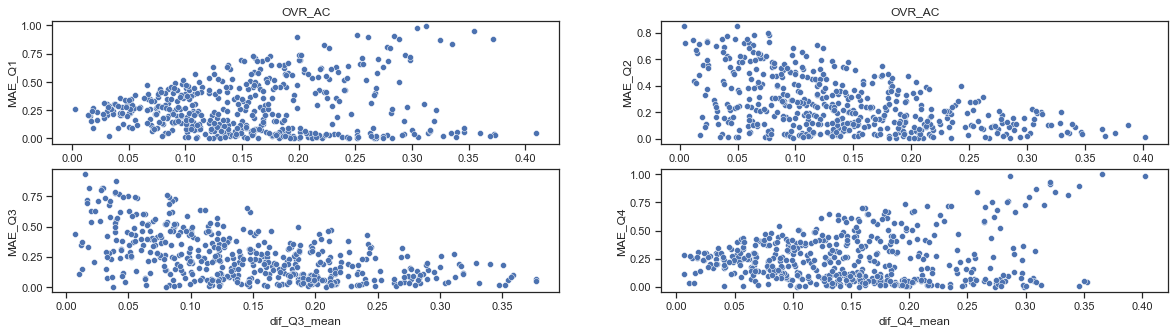

,MAE_Q1,MAE_Q2,MAE_Q3,MAE_Q4,dif_Q1_mean,dif_Q2_mean,dif_Q3_mean,dif_Q4_mean
min,0.000,0.001,0.001,0.00079,0.002889,0.003778,0.007556,0.006444
max,0.993,0.849,0.933,0.99900,0.409778,0.401778,0.377333,0.402667


In [14]:
plt_MAE_DIFhomo(df_filtrado_OVR,'OVR_AC')

<AxesSubplot:xlabel='dif_Q1_mean', ylabel='MAE_Q1'>

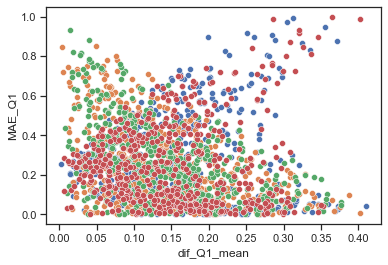

In [15]:
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q1_mean", y="MAE_Q1")
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q2_mean", y="MAE_Q2")
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q3_mean", y="MAE_Q3")
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q4_mean", y="MAE_Q4")

### <font color="#CA3532">  Caso 0VR-HDX

In [16]:
df_filtrado_OVR=Dist_Homo_MAE(df_proba_real,'OVR-HDx')
df_filtrado_OVR

,index,nmethod,nbags,nreps,Est_name,ntrain,P_REAL_class_1,P_REAL_class_2,P_REAL_class_3,P_REAL_class_4,...,Q2_diff,dif_Q1_HOMO,dif_Q2_mean,MAE_Q2,Q3_diff,dif_Q3_mean,MAE_Q3,Q4_diff,dif_Q4_mean,MAE_Q4
9,0,OVR-HDx,50,10,LR,1000,0.056,0.617,0.231,0.096,...,0.383,0.245333,0.068889,0.151163,0.769,0.240444,0.069821,0.904,0.210444,0.019884
21,0,OVR-HDx,50,10,LR,1000,0.101,0.194,0.384,0.321,...,0.806,0.125333,0.111778,0.154214,0.616,0.077111,0.135680,0.679,0.105111,0.067772
33,0,OVR-HDx,50,10,LR,1000,0.175,0.246,0.258,0.321,...,0.754,0.051333,0.050889,0.131254,0.742,0.049111,0.137457,0.679,0.034222,0.011839
45,0,OVR-HDx,50,10,LR,1000,0.327,0.396,0.103,0.174,...,0.604,0.051667,0.083778,0.075843,0.897,0.083333,0.082163,0.826,0.114889,0.072843
57,0,OVR-HDx,50,10,LR,1000,0.116,0.282,0.069,0.533,...,0.718,0.039667,0.195778,0.282000,0.931,0.148444,0.427338,0.467,0.084222,0.087300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5949,0,OVR-HDx,50,10,LR,1000,0.395,0.035,0.086,0.484,...,0.965,0.223000,0.157111,0.035000,0.914,0.179778,0.129115,0.516,0.148667,0.002029
5961,0,OVR-HDx,50,10,LR,1000,0.246,0.293,0.371,0.090,...,0.707,0.057333,0.097111,0.119855,0.629,0.079778,0.176527,0.910,0.045111,0.029737
5973,0,OVR-HDx,50,10,LR,1000,0.320,0.116,0.336,0.228,...,0.884,0.062667,0.044444,0.145873,0.664,0.070222,0.074974,0.772,0.094222,0.002639
5985,0,OVR-HDx,50,10,LR,1000,0.230,0.140,0.377,0.253,...,0.860,0.019000,0.060222,0.030900,0.623,0.045111,0.028223,0.747,0.085333,0.046231


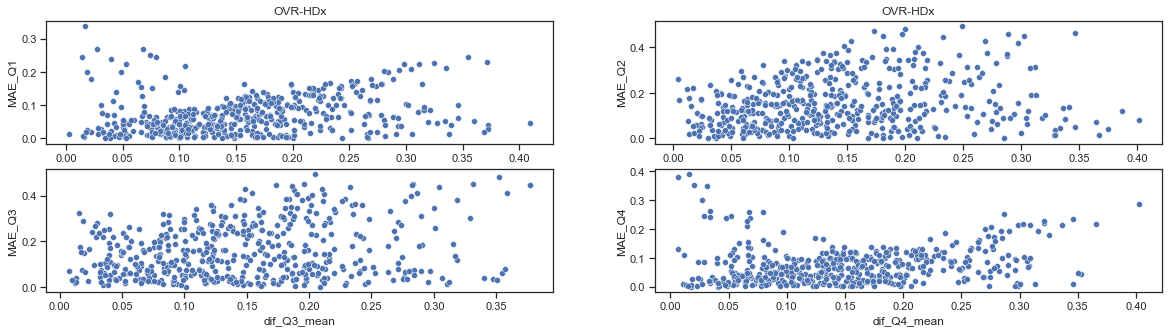

,MAE_Q1,MAE_Q2,MAE_Q3,MAE_Q4,dif_Q1_mean,dif_Q2_mean,dif_Q3_mean,dif_Q4_mean
min,0.000001,0.000264,0.000534,0.000142,0.002889,0.003778,0.007556,0.006444
max,0.338023,0.494002,0.492664,0.388810,0.409778,0.401778,0.377333,0.402667


In [17]:
plt_MAE_DIFhomo(df_filtrado_OVR,'OVR-HDx')

q1 y q4 son muy simétricas ,y la 2 contra 3 simetricas

<AxesSubplot:xlabel='dif_Q1_mean', ylabel='MAE_Q1'>

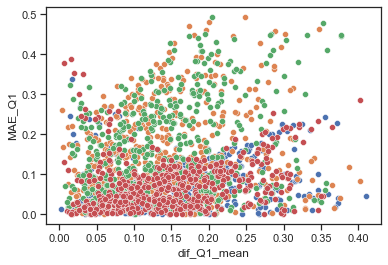

In [18]:
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q1_mean", y="MAE_Q1")
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q2_mean", y="MAE_Q2")
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q3_mean", y="MAE_Q3")
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q4_mean", y="MAE_Q4")

### <font color="#CA3532">  Caso 0VR-HDY
    

In [19]:
df_filtrado_OVR=Dist_Homo_MAE(df_proba_real,'OVR-HDy')
df_filtrado_OVR

,index,nmethod,nbags,nreps,Est_name,ntrain,P_REAL_class_1,P_REAL_class_2,P_REAL_class_3,P_REAL_class_4,...,Q2_diff,dif_Q1_HOMO,dif_Q2_mean,MAE_Q2,Q3_diff,dif_Q3_mean,MAE_Q3,Q4_diff,dif_Q4_mean,MAE_Q4
8,0,OVR-HDy,50,10,LR,1000,0.056,0.617,0.231,0.096,...,0.383,0.245333,0.068889,0.138003,0.769,0.240444,0.096118,0.904,0.210444,0.035093
20,0,OVR-HDy,50,10,LR,1000,0.101,0.194,0.384,0.321,...,0.806,0.125333,0.111778,0.116183,0.616,0.077111,0.122003,0.679,0.105111,0.036186
32,0,OVR-HDy,50,10,LR,1000,0.175,0.246,0.258,0.321,...,0.754,0.051333,0.050889,0.089757,0.742,0.049111,0.127379,0.679,0.034222,0.018492
44,0,OVR-HDy,50,10,LR,1000,0.327,0.396,0.103,0.174,...,0.604,0.051667,0.083778,0.059660,0.897,0.083333,0.033594,0.826,0.114889,0.076763
56,0,OVR-HDy,50,10,LR,1000,0.116,0.282,0.069,0.533,...,0.718,0.039667,0.195778,0.258135,0.931,0.148444,0.382604,0.467,0.084222,0.092825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5948,0,OVR-HDy,50,10,LR,1000,0.395,0.035,0.086,0.484,...,0.965,0.223000,0.157111,0.029893,0.914,0.179778,0.011021,0.516,0.148667,0.045423
5960,0,OVR-HDy,50,10,LR,1000,0.246,0.293,0.371,0.090,...,0.707,0.057333,0.097111,0.120286,0.629,0.079778,0.137061,0.910,0.045111,0.016793
5972,0,OVR-HDy,50,10,LR,1000,0.320,0.116,0.336,0.228,...,0.884,0.062667,0.044444,0.127452,0.664,0.070222,0.082767,0.772,0.094222,0.020097
5984,0,OVR-HDy,50,10,LR,1000,0.230,0.140,0.377,0.253,...,0.860,0.019000,0.060222,0.022091,0.623,0.045111,0.018975,0.747,0.085333,0.043659


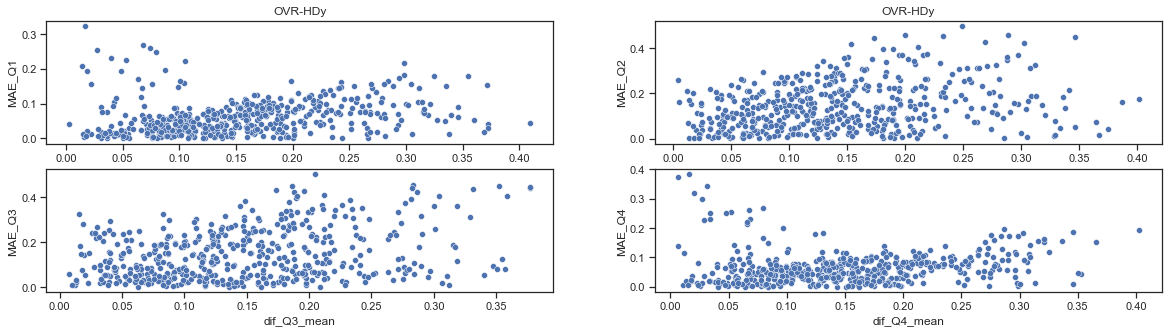

,MAE_Q1,MAE_Q2,MAE_Q3,MAE_Q4,dif_Q1_mean,dif_Q2_mean,dif_Q3_mean,dif_Q4_mean
min,0.000004,0.000348,0.000740,0.000333,0.002889,0.003778,0.007556,0.006444
max,0.322463,0.497248,0.500186,0.382927,0.409778,0.401778,0.377333,0.402667


In [20]:
plt_MAE_DIFhomo(df_filtrado_OVR,'OVR-HDy')

Se muestra simetría igual que antes

<AxesSubplot:xlabel='dif_Q1_mean', ylabel='MAE_Q1'>

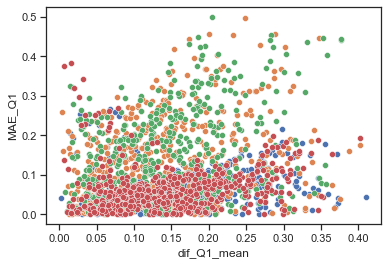

In [21]:
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q1_mean", y="MAE_Q1")
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q2_mean", y="MAE_Q2")
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q3_mean", y="MAE_Q3")
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q4_mean", y="MAE_Q4")

### <font color="#CA3532">  Caso 0VR-EDX

In [22]:
df_filtrado_OVR=Dist_Homo_MAE(df_proba_real,'OVR-EDX')
df_filtrado_OVR

,index,nmethod,nbags,nreps,Est_name,ntrain,P_REAL_class_1,P_REAL_class_2,P_REAL_class_3,P_REAL_class_4,...,Q2_diff,dif_Q1_HOMO,dif_Q2_mean,MAE_Q2,Q3_diff,dif_Q3_mean,MAE_Q3,Q4_diff,dif_Q4_mean,MAE_Q4
10,0,OVR-EDX,50,10,LR,1000,0.056,0.617,0.231,0.096,...,0.383,0.245333,0.068889,0.167042,0.769,0.240444,0.038473,0.904,0.210444,0.026833
22,0,OVR-EDX,50,10,LR,1000,0.101,0.194,0.384,0.321,...,0.806,0.125333,0.111778,0.194000,0.616,0.077111,0.202965,0.679,0.105111,0.066235
34,0,OVR-EDX,50,10,LR,1000,0.175,0.246,0.258,0.321,...,0.754,0.051333,0.050889,0.194319,0.742,0.049111,0.196653,0.679,0.034222,0.026843
46,0,OVR-EDX,50,10,LR,1000,0.327,0.396,0.103,0.174,...,0.604,0.051667,0.083778,0.143195,0.897,0.083333,0.103000,0.826,0.114889,0.100549
58,0,OVR-EDX,50,10,LR,1000,0.116,0.282,0.069,0.533,...,0.718,0.039667,0.195778,0.282000,0.931,0.148444,0.500936,0.467,0.084222,0.114729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5950,0,OVR-EDX,50,10,LR,1000,0.395,0.035,0.086,0.484,...,0.965,0.223000,0.157111,0.035000,0.914,0.179778,0.249698,0.516,0.148667,0.058878
5962,0,OVR-EDX,50,10,LR,1000,0.246,0.293,0.371,0.090,...,0.707,0.057333,0.097111,0.143776,0.629,0.079778,0.245987,0.910,0.045111,0.045411
5974,0,OVR-EDX,50,10,LR,1000,0.320,0.116,0.336,0.228,...,0.884,0.062667,0.044444,0.149101,0.664,0.070222,0.097340,0.772,0.094222,0.011162
5986,0,OVR-EDX,50,10,LR,1000,0.230,0.140,0.377,0.253,...,0.860,0.019000,0.060222,0.028380,0.623,0.045111,0.021448,0.747,0.085333,0.065003


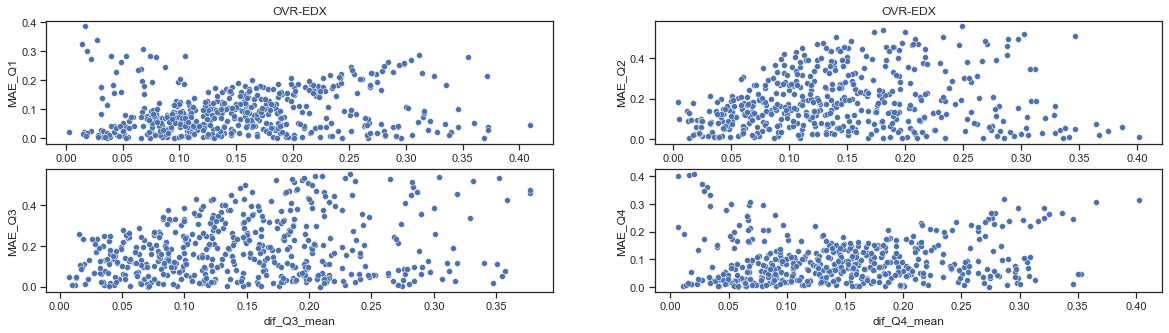

,MAE_Q1,MAE_Q2,MAE_Q3,MAE_Q4,dif_Q1_mean,dif_Q2_mean,dif_Q3_mean,dif_Q4_mean
min,0.000000,0.002000,0.000332,0.000448,0.002889,0.003778,0.007556,0.006444
max,0.387207,0.560912,0.550807,0.407603,0.409778,0.401778,0.377333,0.402667


In [23]:
plt_MAE_DIFhomo(df_filtrado_OVR,'OVR-EDX')

In [24]:
df_filtrado_OVR

,index,nmethod,nbags,nreps,Est_name,ntrain,P_REAL_class_1,P_REAL_class_2,P_REAL_class_3,P_REAL_class_4,...,Q2_diff,dif_Q1_HOMO,dif_Q2_mean,MAE_Q2,Q3_diff,dif_Q3_mean,MAE_Q3,Q4_diff,dif_Q4_mean,MAE_Q4
10,0,OVR-EDX,50,10,LR,1000,0.056,0.617,0.231,0.096,...,0.383,0.245333,0.068889,0.167042,0.769,0.240444,0.038473,0.904,0.210444,0.026833
22,0,OVR-EDX,50,10,LR,1000,0.101,0.194,0.384,0.321,...,0.806,0.125333,0.111778,0.194000,0.616,0.077111,0.202965,0.679,0.105111,0.066235
34,0,OVR-EDX,50,10,LR,1000,0.175,0.246,0.258,0.321,...,0.754,0.051333,0.050889,0.194319,0.742,0.049111,0.196653,0.679,0.034222,0.026843
46,0,OVR-EDX,50,10,LR,1000,0.327,0.396,0.103,0.174,...,0.604,0.051667,0.083778,0.143195,0.897,0.083333,0.103000,0.826,0.114889,0.100549
58,0,OVR-EDX,50,10,LR,1000,0.116,0.282,0.069,0.533,...,0.718,0.039667,0.195778,0.282000,0.931,0.148444,0.500936,0.467,0.084222,0.114729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5950,0,OVR-EDX,50,10,LR,1000,0.395,0.035,0.086,0.484,...,0.965,0.223000,0.157111,0.035000,0.914,0.179778,0.249698,0.516,0.148667,0.058878
5962,0,OVR-EDX,50,10,LR,1000,0.246,0.293,0.371,0.090,...,0.707,0.057333,0.097111,0.143776,0.629,0.079778,0.245987,0.910,0.045111,0.045411
5974,0,OVR-EDX,50,10,LR,1000,0.320,0.116,0.336,0.228,...,0.884,0.062667,0.044444,0.149101,0.664,0.070222,0.097340,0.772,0.094222,0.011162
5986,0,OVR-EDX,50,10,LR,1000,0.230,0.140,0.377,0.253,...,0.860,0.019000,0.060222,0.028380,0.623,0.045111,0.021448,0.747,0.085333,0.065003


<AxesSubplot:xlabel='dif_Q1_mean', ylabel='MAE_Q1'>

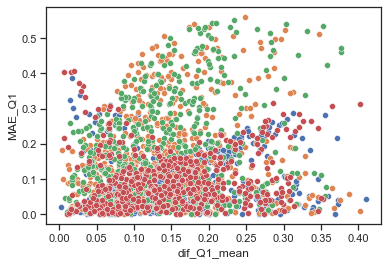

In [25]:
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q1_mean", y="MAE_Q1")
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q2_mean", y="MAE_Q2")
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q3_mean", y="MAE_Q3")
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q4_mean", y="MAE_Q4")

In [26]:
# Para la clase 4
# Filtrar en EDX mae > 0.2 diferencia homogenea < 0.10 
# la idea es ver que pasa con los puntos que están fuera de la


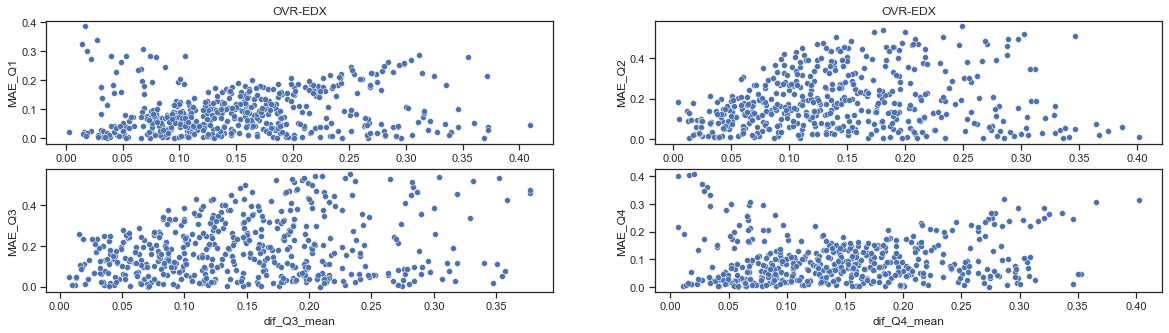

,MAE_Q1,MAE_Q2,MAE_Q3,MAE_Q4,dif_Q1_mean,dif_Q2_mean,dif_Q3_mean,dif_Q4_mean
min,0.000000,0.002000,0.000332,0.000448,0.002889,0.003778,0.007556,0.006444
max,0.387207,0.560912,0.550807,0.407603,0.409778,0.401778,0.377333,0.402667


In [27]:
plt_MAE_DIFhomo(df_filtrado_OVR,'OVR-EDX')

In [28]:
df_filtrado_OVR

,index,nmethod,nbags,nreps,Est_name,ntrain,P_REAL_class_1,P_REAL_class_2,P_REAL_class_3,P_REAL_class_4,...,Q2_diff,dif_Q1_HOMO,dif_Q2_mean,MAE_Q2,Q3_diff,dif_Q3_mean,MAE_Q3,Q4_diff,dif_Q4_mean,MAE_Q4
10,0,OVR-EDX,50,10,LR,1000,0.056,0.617,0.231,0.096,...,0.383,0.245333,0.068889,0.167042,0.769,0.240444,0.038473,0.904,0.210444,0.026833
22,0,OVR-EDX,50,10,LR,1000,0.101,0.194,0.384,0.321,...,0.806,0.125333,0.111778,0.194000,0.616,0.077111,0.202965,0.679,0.105111,0.066235
34,0,OVR-EDX,50,10,LR,1000,0.175,0.246,0.258,0.321,...,0.754,0.051333,0.050889,0.194319,0.742,0.049111,0.196653,0.679,0.034222,0.026843
46,0,OVR-EDX,50,10,LR,1000,0.327,0.396,0.103,0.174,...,0.604,0.051667,0.083778,0.143195,0.897,0.083333,0.103000,0.826,0.114889,0.100549
58,0,OVR-EDX,50,10,LR,1000,0.116,0.282,0.069,0.533,...,0.718,0.039667,0.195778,0.282000,0.931,0.148444,0.500936,0.467,0.084222,0.114729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5950,0,OVR-EDX,50,10,LR,1000,0.395,0.035,0.086,0.484,...,0.965,0.223000,0.157111,0.035000,0.914,0.179778,0.249698,0.516,0.148667,0.058878
5962,0,OVR-EDX,50,10,LR,1000,0.246,0.293,0.371,0.090,...,0.707,0.057333,0.097111,0.143776,0.629,0.079778,0.245987,0.910,0.045111,0.045411
5974,0,OVR-EDX,50,10,LR,1000,0.320,0.116,0.336,0.228,...,0.884,0.062667,0.044444,0.149101,0.664,0.070222,0.097340,0.772,0.094222,0.011162
5986,0,OVR-EDX,50,10,LR,1000,0.230,0.140,0.377,0.253,...,0.860,0.019000,0.060222,0.028380,0.623,0.045111,0.021448,0.747,0.085333,0.065003


### <font color="#CA3532">  Caso EDYdf_proba_real

In [29]:
df_filtrado_OVR=Dist_Homo_MAE(df_proba_real,'EDy')
df_filtrado_OVR

,index,nmethod,nbags,nreps,Est_name,ntrain,P_REAL_class_1,P_REAL_class_2,P_REAL_class_3,P_REAL_class_4,...,Q2_diff,dif_Q1_HOMO,dif_Q2_mean,MAE_Q2,Q3_diff,dif_Q3_mean,MAE_Q3,Q4_diff,dif_Q4_mean,MAE_Q4
5,0,EDy,50,10,LR,1000,0.056,0.617,0.231,0.096,...,0.383,0.245333,0.068889,0.033831,0.769,0.240444,0.030865,0.904,0.210444,0.011572
17,0,EDy,50,10,LR,1000,0.101,0.194,0.384,0.321,...,0.806,0.125333,0.111778,0.036774,0.616,0.077111,0.018637,0.679,0.105111,0.005114
29,0,EDy,50,10,LR,1000,0.175,0.246,0.258,0.321,...,0.754,0.051333,0.050889,0.088118,0.742,0.049111,0.107974,0.679,0.034222,0.052509
41,0,EDy,50,10,LR,1000,0.327,0.396,0.103,0.174,...,0.604,0.051667,0.083778,0.061649,0.897,0.083333,0.074244,0.826,0.114889,0.022546
53,0,EDy,50,10,LR,1000,0.116,0.282,0.069,0.533,...,0.718,0.039667,0.195778,0.005959,0.931,0.148444,0.050598,0.467,0.084222,0.030145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5945,0,EDy,50,10,LR,1000,0.395,0.035,0.086,0.484,...,0.965,0.223000,0.157111,0.063561,0.914,0.179778,0.031926,0.516,0.148667,0.003188
5957,0,EDy,50,10,LR,1000,0.246,0.293,0.371,0.090,...,0.707,0.057333,0.097111,0.010510,0.629,0.079778,0.021811,0.910,0.045111,0.009255
5969,0,EDy,50,10,LR,1000,0.320,0.116,0.336,0.228,...,0.884,0.062667,0.044444,0.080838,0.664,0.070222,0.047703,0.772,0.094222,0.005261
5981,0,EDy,50,10,LR,1000,0.230,0.140,0.377,0.253,...,0.860,0.019000,0.060222,0.019847,0.623,0.045111,0.017041,0.747,0.085333,0.003676


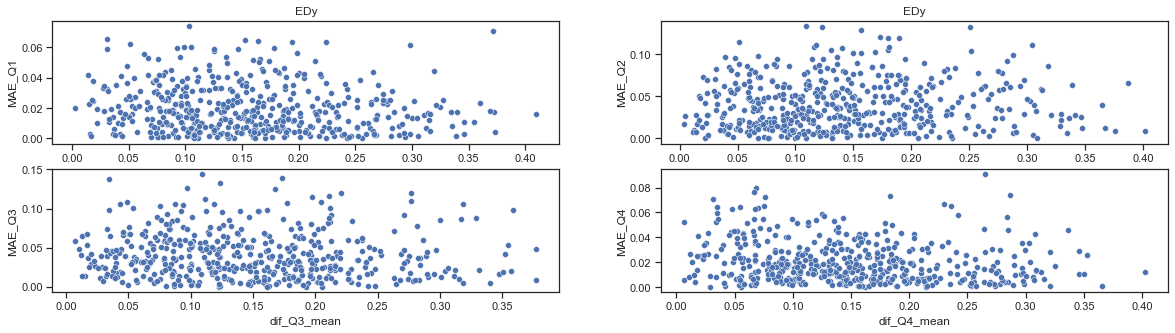

,MAE_Q1,MAE_Q2,MAE_Q3,MAE_Q4,dif_Q1_mean,dif_Q2_mean,dif_Q3_mean,dif_Q4_mean
min,0.000000,0.000004,0.000089,0.000175,0.002889,0.003778,0.007556,0.006444
max,0.073968,0.133227,0.143614,0.090713,0.409778,0.401778,0.377333,0.402667


In [30]:
plt_MAE_DIFhomo(df_filtrado_OVR,'EDy')

In [31]:
df_filtrado_OVR

,index,nmethod,nbags,nreps,Est_name,ntrain,P_REAL_class_1,P_REAL_class_2,P_REAL_class_3,P_REAL_class_4,...,Q2_diff,dif_Q1_HOMO,dif_Q2_mean,MAE_Q2,Q3_diff,dif_Q3_mean,MAE_Q3,Q4_diff,dif_Q4_mean,MAE_Q4
5,0,EDy,50,10,LR,1000,0.056,0.617,0.231,0.096,...,0.383,0.245333,0.068889,0.033831,0.769,0.240444,0.030865,0.904,0.210444,0.011572
17,0,EDy,50,10,LR,1000,0.101,0.194,0.384,0.321,...,0.806,0.125333,0.111778,0.036774,0.616,0.077111,0.018637,0.679,0.105111,0.005114
29,0,EDy,50,10,LR,1000,0.175,0.246,0.258,0.321,...,0.754,0.051333,0.050889,0.088118,0.742,0.049111,0.107974,0.679,0.034222,0.052509
41,0,EDy,50,10,LR,1000,0.327,0.396,0.103,0.174,...,0.604,0.051667,0.083778,0.061649,0.897,0.083333,0.074244,0.826,0.114889,0.022546
53,0,EDy,50,10,LR,1000,0.116,0.282,0.069,0.533,...,0.718,0.039667,0.195778,0.005959,0.931,0.148444,0.050598,0.467,0.084222,0.030145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5945,0,EDy,50,10,LR,1000,0.395,0.035,0.086,0.484,...,0.965,0.223000,0.157111,0.063561,0.914,0.179778,0.031926,0.516,0.148667,0.003188
5957,0,EDy,50,10,LR,1000,0.246,0.293,0.371,0.090,...,0.707,0.057333,0.097111,0.010510,0.629,0.079778,0.021811,0.910,0.045111,0.009255
5969,0,EDy,50,10,LR,1000,0.320,0.116,0.336,0.228,...,0.884,0.062667,0.044444,0.080838,0.664,0.070222,0.047703,0.772,0.094222,0.005261
5981,0,EDy,50,10,LR,1000,0.230,0.140,0.377,0.253,...,0.860,0.019000,0.060222,0.019847,0.623,0.045111,0.017041,0.747,0.085333,0.003676


<AxesSubplot:xlabel='dif_Q1_mean', ylabel='MAE_Q1'>

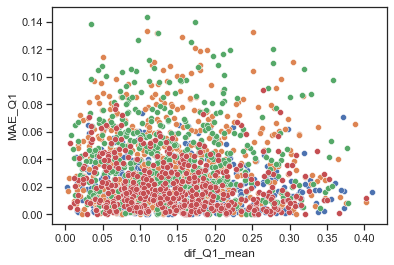

In [32]:
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q1_mean", y="MAE_Q1")
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q2_mean", y="MAE_Q2")
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q3_mean", y="MAE_Q3")
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q4_mean", y="MAE_Q4")

### <font color="#CA3532">  Caso 0VR-EDY

In [33]:
df_filtrado_OVR=Dist_Homo_MAE(df_proba_real,'OVR-EDy')
df_filtrado_OVR

,index,nmethod,nbags,nreps,Est_name,ntrain,P_REAL_class_1,P_REAL_class_2,P_REAL_class_3,P_REAL_class_4,...,Q2_diff,dif_Q1_HOMO,dif_Q2_mean,MAE_Q2,Q3_diff,dif_Q3_mean,MAE_Q3,Q4_diff,dif_Q4_mean,MAE_Q4
11,0,OVR-EDy,50,10,LR,1000,0.056,0.617,0.231,0.096,...,0.383,0.245333,0.068889,0.169513,0.769,0.240444,0.073227,0.904,0.210444,0.021537
23,0,OVR-EDy,50,10,LR,1000,0.101,0.194,0.384,0.321,...,0.806,0.125333,0.111778,0.144692,0.616,0.077111,0.128870,0.679,0.105111,0.080165
35,0,OVR-EDy,50,10,LR,1000,0.175,0.246,0.258,0.321,...,0.754,0.051333,0.050889,0.102565,0.742,0.049111,0.123775,0.679,0.034222,0.006368
47,0,OVR-EDy,50,10,LR,1000,0.327,0.396,0.103,0.174,...,0.604,0.051667,0.083778,0.055314,0.897,0.083333,0.050692,0.826,0.114889,0.088344
59,0,OVR-EDy,50,10,LR,1000,0.116,0.282,0.069,0.533,...,0.718,0.039667,0.195778,0.282000,0.931,0.148444,0.381538,0.467,0.084222,0.042743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5951,0,OVR-EDy,50,10,LR,1000,0.395,0.035,0.086,0.484,...,0.965,0.223000,0.157111,0.035000,0.914,0.179778,0.038918,0.516,0.148667,0.044342
5963,0,OVR-EDy,50,10,LR,1000,0.246,0.293,0.371,0.090,...,0.707,0.057333,0.097111,0.102716,0.629,0.079778,0.145180,0.910,0.045111,0.027252
5975,0,OVR-EDy,50,10,LR,1000,0.320,0.116,0.336,0.228,...,0.884,0.062667,0.044444,0.129791,0.664,0.070222,0.095331,0.772,0.094222,0.023742
5987,0,OVR-EDy,50,10,LR,1000,0.230,0.140,0.377,0.253,...,0.860,0.019000,0.060222,0.022365,0.623,0.045111,0.021960,0.747,0.085333,0.055958


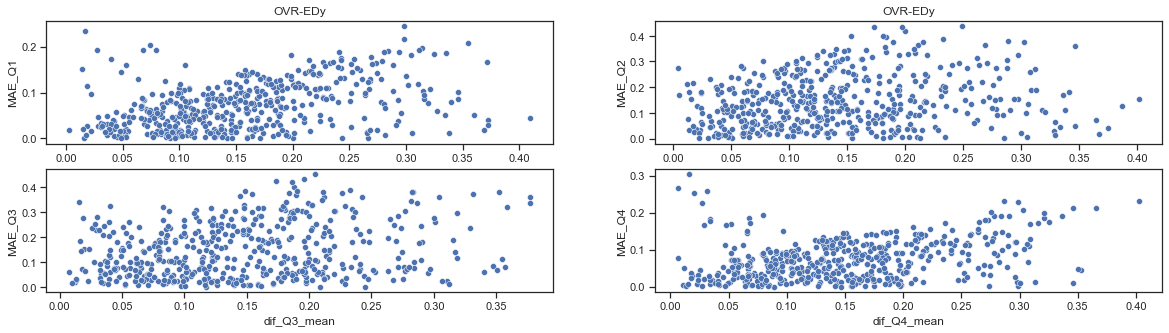

,MAE_Q1,MAE_Q2,MAE_Q3,MAE_Q4,dif_Q1_mean,dif_Q2_mean,dif_Q3_mean,dif_Q4_mean
min,0.000000,0.000296,0.000882,0.000136,0.002889,0.003778,0.007556,0.006444
max,0.244884,0.437829,0.449939,0.303080,0.409778,0.401778,0.377333,0.402667


In [34]:
plt_MAE_DIFhomo(df_filtrado_OVR,'OVR-EDy')

In [35]:
df_filtrado_OVR

,index,nmethod,nbags,nreps,Est_name,ntrain,P_REAL_class_1,P_REAL_class_2,P_REAL_class_3,P_REAL_class_4,...,Q2_diff,dif_Q1_HOMO,dif_Q2_mean,MAE_Q2,Q3_diff,dif_Q3_mean,MAE_Q3,Q4_diff,dif_Q4_mean,MAE_Q4
11,0,OVR-EDy,50,10,LR,1000,0.056,0.617,0.231,0.096,...,0.383,0.245333,0.068889,0.169513,0.769,0.240444,0.073227,0.904,0.210444,0.021537
23,0,OVR-EDy,50,10,LR,1000,0.101,0.194,0.384,0.321,...,0.806,0.125333,0.111778,0.144692,0.616,0.077111,0.128870,0.679,0.105111,0.080165
35,0,OVR-EDy,50,10,LR,1000,0.175,0.246,0.258,0.321,...,0.754,0.051333,0.050889,0.102565,0.742,0.049111,0.123775,0.679,0.034222,0.006368
47,0,OVR-EDy,50,10,LR,1000,0.327,0.396,0.103,0.174,...,0.604,0.051667,0.083778,0.055314,0.897,0.083333,0.050692,0.826,0.114889,0.088344
59,0,OVR-EDy,50,10,LR,1000,0.116,0.282,0.069,0.533,...,0.718,0.039667,0.195778,0.282000,0.931,0.148444,0.381538,0.467,0.084222,0.042743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5951,0,OVR-EDy,50,10,LR,1000,0.395,0.035,0.086,0.484,...,0.965,0.223000,0.157111,0.035000,0.914,0.179778,0.038918,0.516,0.148667,0.044342
5963,0,OVR-EDy,50,10,LR,1000,0.246,0.293,0.371,0.090,...,0.707,0.057333,0.097111,0.102716,0.629,0.079778,0.145180,0.910,0.045111,0.027252
5975,0,OVR-EDy,50,10,LR,1000,0.320,0.116,0.336,0.228,...,0.884,0.062667,0.044444,0.129791,0.664,0.070222,0.095331,0.772,0.094222,0.023742
5987,0,OVR-EDy,50,10,LR,1000,0.230,0.140,0.377,0.253,...,0.860,0.019000,0.060222,0.022365,0.623,0.045111,0.021960,0.747,0.085333,0.055958


<AxesSubplot:xlabel='dif_Q1_mean', ylabel='MAE_Q1'>

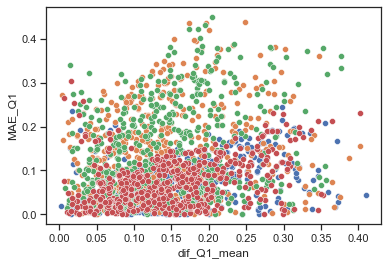

In [36]:
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q1_mean", y="MAE_Q1")
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q2_mean", y="MAE_Q2")
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q3_mean", y="MAE_Q3")
sns.scatterplot(data=df_filtrado_OVR, x="dif_Q4_mean", y="MAE_Q4")

<AxesSubplot:xlabel='P_REAL_class_4', ylabel='P_EST_class_4'>

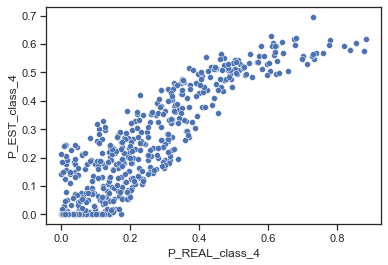

In [37]:
sns.scatterplot(data=df_filtrado_OVR, x="P_REAL_class_4", y="P_EST_class_4")